# Penalized Cox Models
Cox’s proportional hazard’s model is often an appealing model, because its coefficients can be interpreted in terms of hazard ratio, which often provides valuable insight. However, if we want to estimate the coefficients of many features, the standard Cox model falls apart, because internally it tries to invert a matrix that becomes non-singular due to correlations among features.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob, inspect, sys
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

In [2]:
def calc_median_survival(survival_func):
    '''
    Calculate the median survival as the time when survival probability falls below 0.5
    If it doesn't fall below 0.5 then it will be set as the last time point observed
    Args:
    - survival_func: array of survival functions returned by predict_survival_function()
    returns: 
    - median_survival_list: list of median survival times
    '''
    median_survival_list = []
    for fn in survival_func:
        found_list = np.where(fn(fn.x) <= 0.5)[0]
        if len(found_list) != 0:
            found_index = np.min(found_list)
            median_survival_list.append(fn.x[found_index])
        else:
            median_survival_list.append(fn.x[len(fn.x)-1])
    return median_survival_list

In [3]:
def score_survival_model_ipcw(model, X_test, y_train, y_test):
    '''args: 
    -model
    -X_test
    -y_train
    -y_test'''
    prediction = model.predict(X_test)
    if not getattr(model, "_predict_risk_score", True):
        prediction *= -1  # convert prediction on time scale to risk scale
    result = concordance_index_ipcw(y_train, y_test, prediction)
    return result[0]

In [4]:
df = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)


In [5]:
df_y=df.iloc[:, :2]
df_x=df.iloc[:, 2:]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=7)


In [7]:
X_train.columns

Index(['NDE_cycle', 'diff_two_peaks_ratio', 'amp_ratio', 'pos_ratio',
       'energy_ratio', 'NLE_ratio_51_17', 'NLE_ratio_85_17',
       'NLE_ratio_51_119', 'NLO_avg', 'Avg_RP', 'ACEE_30_Avg_58',
       'ACEE_500_Avg_58', 'ACPD_Avg_58'],
      dtype='object')

In [8]:
y_train=y_train.to_records(index=False)
y_test=y_test.to_records(index=False)

CoxPHSurvivalAnalysis and CoxnetSurvivalAnalysis are related but do not implement the same model. As you summarized, the difference is in penalty terms. Thus, the coefficients found by CoxPHSurvivalAnalysis and CoxnetSurvivalAnalysis will differ. In addition, CoxnetSurvivalAnalysis supports fitting a path of coefficients for varying penalization strength alpha without much computational overhead. CoxPHSurvivalAnalysis will return the result for a single a penalization strength alpha only. This is the main reason why constructors differ.

Run a gridsearch to find which subset and α generalizes best

### if we obtain a  low score for ipcw we can lower the l1_ratio value to obtain a better score so we run the grid search again with l1_ratio=0.5 and since we choose this value because it gave us a higher score

In [9]:
alphas = 10. ** np.linspace(-4, 4, 50) # me make a list of alphas

In [10]:
cv = KFold(n_splits=2, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(MinMaxScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.5)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)



# Survival and Cumulative Hazard Function
Having selected a particular α through setting penality parameter l1_ratio to 0.9, we can perform prediction, either in terms of risk score using the predict function or in terms of survival or cumulative hazard function. For the latter two, we first need to re-fit the model with fit_baseline_model enabled.

In [11]:
#using predict function for train dataset
coxnet_pred = make_pipeline(
    MinMaxScaler(),
    CoxnetSurvivalAnalysis()
)
coxnet_pred.set_params(**gcv.best_params_)
surv_func=coxnet_pred.fit(X_train, y_train)
surv_func


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.02811768697974228]))])

In [12]:
print ("ipcw:", score_survival_model_ipcw(surv_func, X_test, y_train, y_test))

ipcw: 0.4098195818881854


In [13]:
surv_func.score(X_test, y_test)

0.7894736842105263

In [14]:
#using hazard function with baseline model set as True
coxnet_pred = make_pipeline(
    MinMaxScaler(),
    CoxnetSurvivalAnalysis( fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.02811768697974228],
                                        fit_baseline_model=True))])

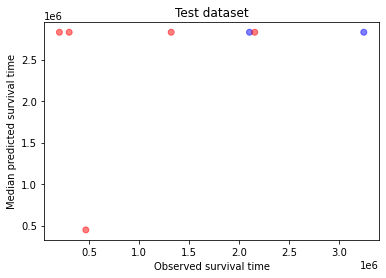

In [15]:
surv_func_test=coxnet_pred.predict_survival_function(X_test)

median_survival_list = calc_median_survival(surv_func_test)

colordict = {False:'blue', True:'red'}
plt.scatter(x=y_test.F_Time,y=median_survival_list,c=[colordict[c] for c in y_test.Observed],alpha=0.5)
plt.ylabel("Median predicted survival time")
plt.xlabel("Observed survival time")
plt.title("Test dataset")
plt.show()

In [16]:
calc_median_survival(surv_func_test)

[2829121.0, 447380.0, 2829121.0, 2829121.0, 2829121.0, 2829121.0, 2829121.0]

ValueError: x must be within [306142.000000; 2829121.000000]

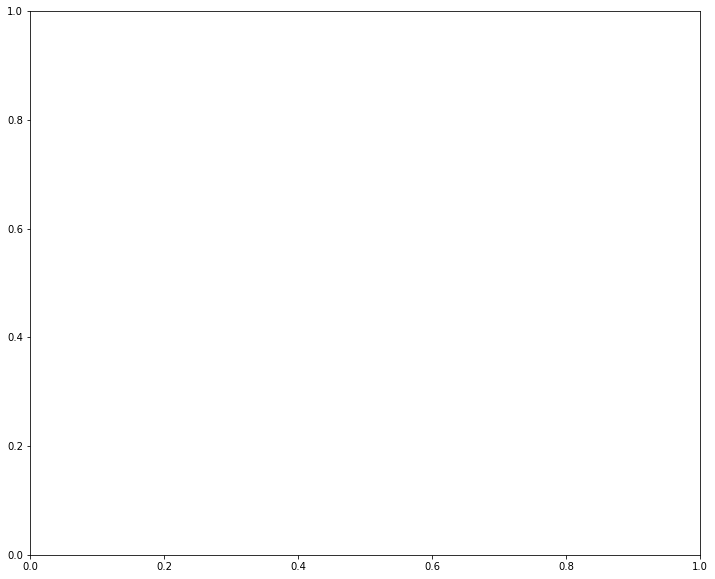

In [17]:

time_points =y_test["F_Time"]
time_points =np.quantile(y_test["F_Time"], np.linspace(0,0.6, 100))

fig, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_func_test, X_test.loc[:, "energy_ratio"]):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 

ax.legend(X_test.index) 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
plt.title("Test dataset")
ax.grid(True)

### surivial function for train dataset

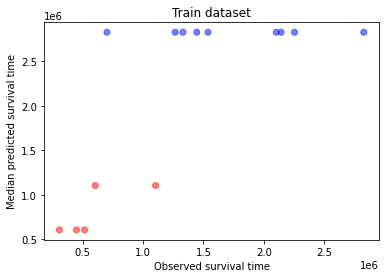

In [18]:
#plotting survival predicted vs observed time for the training data 
surv_func_train=coxnet_pred.predict_survival_function(X_train)

median_survival_list = calc_median_survival(surv_func_train)

colordict = {False:'blue', True:'red'}
plt.scatter(x=y_train.F_Time,y=median_survival_list,c=[colordict[c] for c in y_train.Observed],alpha=0.5)
plt.ylabel("Median predicted survival time")
plt.xlabel("Observed survival time")
plt.title("Train dataset")
plt.show()

In [19]:
calc_median_survival(surv_func_train)

[1103303.0,
 1103303.0,
 2829121.0,
 2829121.0,
 2829121.0,
 2829121.0,
 2829121.0,
 603724.0,
 603724.0,
 2829121.0,
 603724.0,
 2829121.0,
 2829121.0,
 2829121.0]

For instance, we can now select a specimen and determine how a specific feature would affect the survival function.

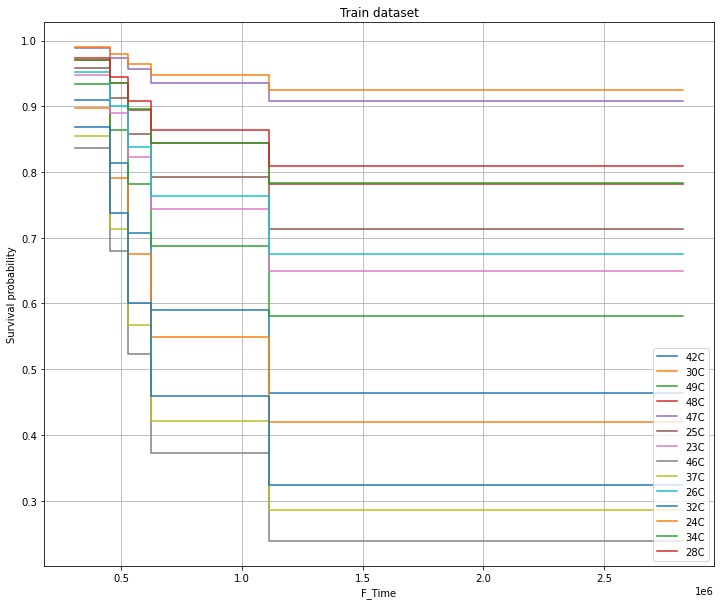

In [20]:
surv_func_train = coxnet_pred.predict_survival_function(X_train)


time_points =y_train["F_Time"]
time_points =np.percentile(y_train["F_Time"], np.linspace(0, 100))

fig, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_func_train, X_train.loc[:, "energy_ratio"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 

ax.legend(X_train.index, loc="lower right") 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
plt.title("Train dataset")
ax.grid(True)

# Plotting survival function for the whole dataset

In [21]:
df_y_all=df_y.copy()
df_y_all=df_y_all.to_records(index=False)

In [22]:
#using hazard function for the whole dataset
coxnet_pred = make_pipeline(
    MinMaxScaler(),
    CoxnetSurvivalAnalysis(fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(df_x, df_y_all)


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.02811768697974228],
                                        fit_baseline_model=True))])

In [23]:
coxnet_pred.score(df_x, df_y_all)

0.8055555555555556

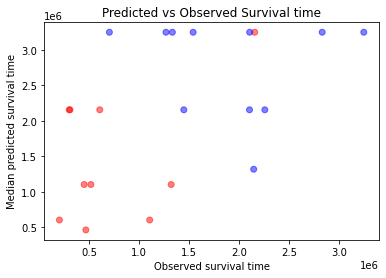

In [24]:
surv_func_all=coxnet_pred.predict_survival_function(df_x)
median_survival_list = calc_median_survival(surv_func_all)
colordict = {False:'blue', True:'red'}
plt.scatter(x=df_y_all.F_Time,y=median_survival_list,c=[colordict[c] for c in df_y_all.Observed],alpha=0.5)
plt.ylabel("Median predicted survival time")
plt.xlabel("Observed survival time")
plt.title("Predicted vs Observed Survival time")
plt.show()

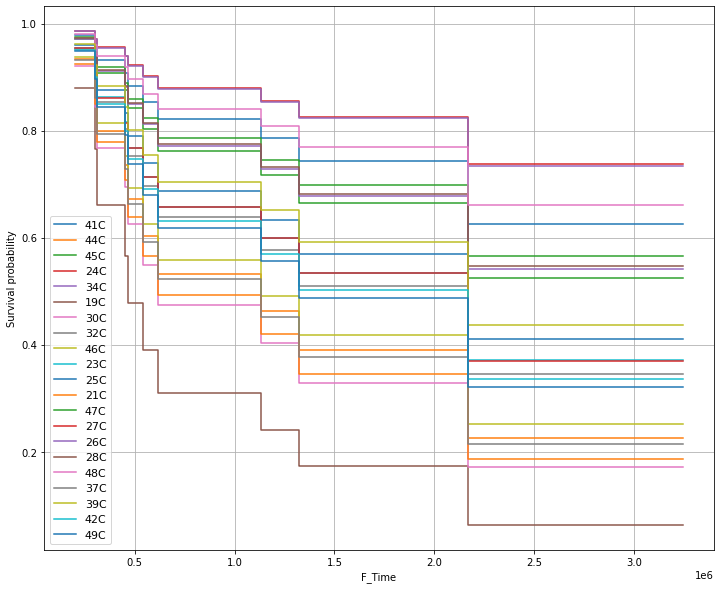

In [25]:
time_points =df_y_all["F_Time"]
time_points =np.percentile(df_y_all["F_Time"], np.linspace(0, 100))

fig, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_func_all, df_x.loc[:, "energy_ratio"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 
plt.rc('font', size=11) 
ax.legend(df_x.index) 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [26]:
df_x.shape

(21, 13)

In [27]:
df_0_6=df_x.iloc[0:6, :]
df_6_11=df_x.iloc[6:11, :]
df_11_16=df_x.iloc[11:16,:]
df_16_21=df_x.iloc[16:,:]


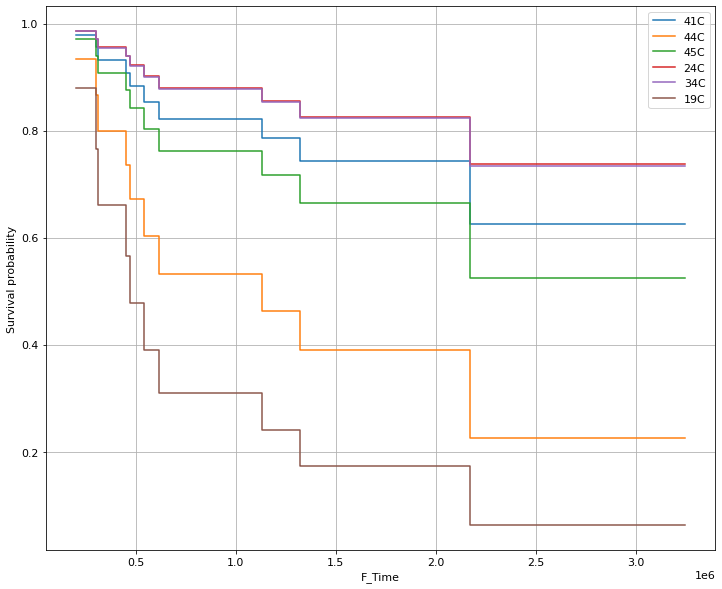

In [28]:
time_points =df_y_all["F_Time"]
time_points =np.percentile(df_y_all["F_Time"], np.linspace(0, 100))

fig, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_func_all, df_0_6.loc[:, "energy_ratio"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 
plt.rc('font', size=11) 
ax.legend(df_0_6.index) 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
ax.grid(True)

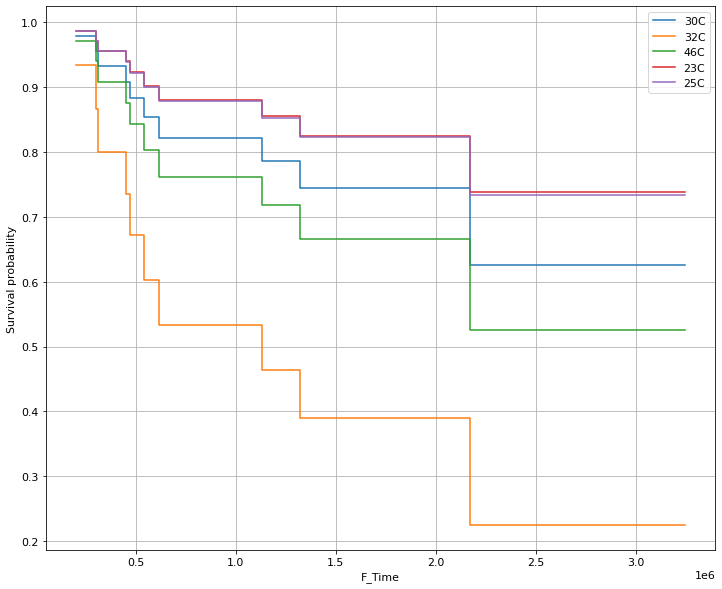

In [29]:
time_points =df_y_all["F_Time"]
time_points =np.percentile(df_y_all["F_Time"], np.linspace(0, 100))

fig, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_func_all, df_6_11.loc[:, "energy_ratio"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 
plt.rc('font', size=11) 
ax.legend(df_6_11.index) 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
ax.grid(True)

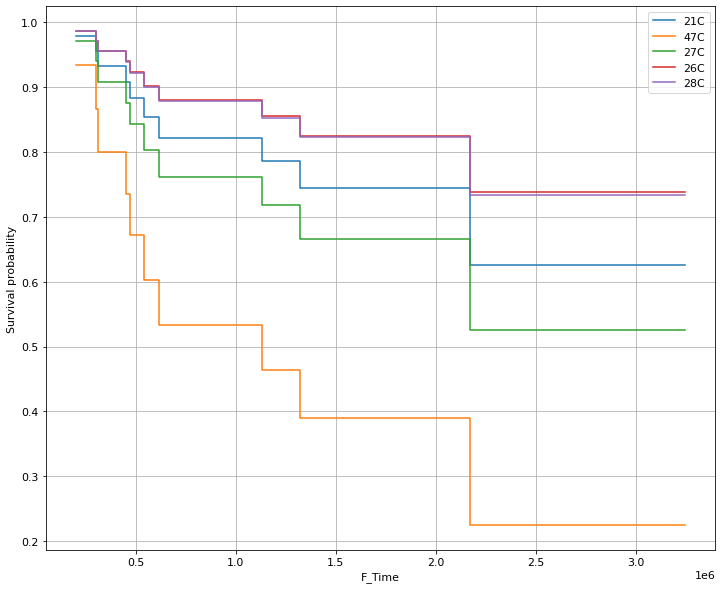

In [30]:
time_points =df_y_all["F_Time"]
time_points =np.percentile(df_y_all["F_Time"], np.linspace(0, 100))

fig, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_func_all, df_11_16.loc[:, "energy_ratio"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 
plt.rc('font', size=11) 
ax.legend(df_11_16.index) 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
ax.grid(True)

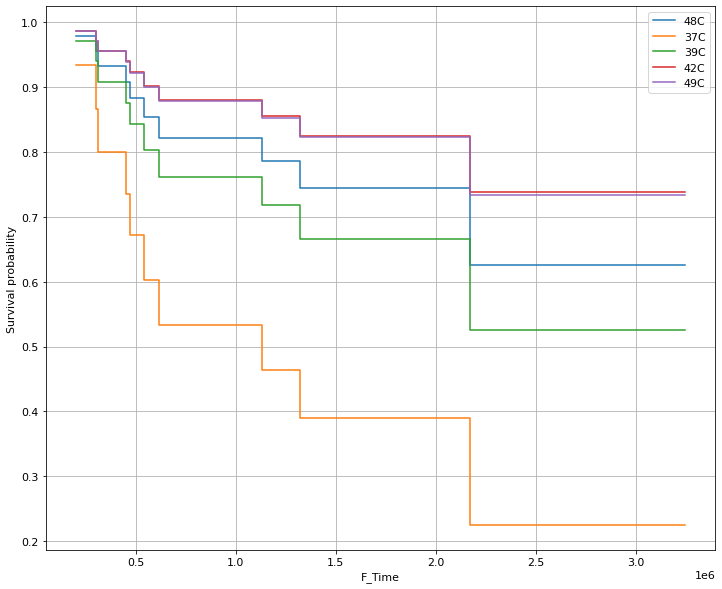

In [31]:
time_points =df_y_all["F_Time"]
time_points =np.percentile(df_y_all["F_Time"], np.linspace(0, 100))

fig, ax = plt.subplots(figsize=(12, 10))
for fn, label in zip(surv_func_all, df_16_21.loc[:, "energy_ratio"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                    alpha=1)
 
plt.rc('font', size=11) 
ax.legend(df_16_21.index) 
ax.set_xlabel("F_Time")
ax.set_ylabel("Survival probability")
ax.grid(True)